In [1]:
import pandas as pd
import numpy as np

df_avax = pd.read_csv('AVAXUSDC.csv')
df_ssv = pd.read_csv('SSVUSDT.csv')


In [3]:
_df_avax=df_avax['Close']
_df_ssv=df_ssv['Close']

In [7]:
avax_pct = _df_avax.pct_change()
ssv_pct = _df_ssv.pct_change()

<Axes: title={'center': 'AVAX - SSV'}>

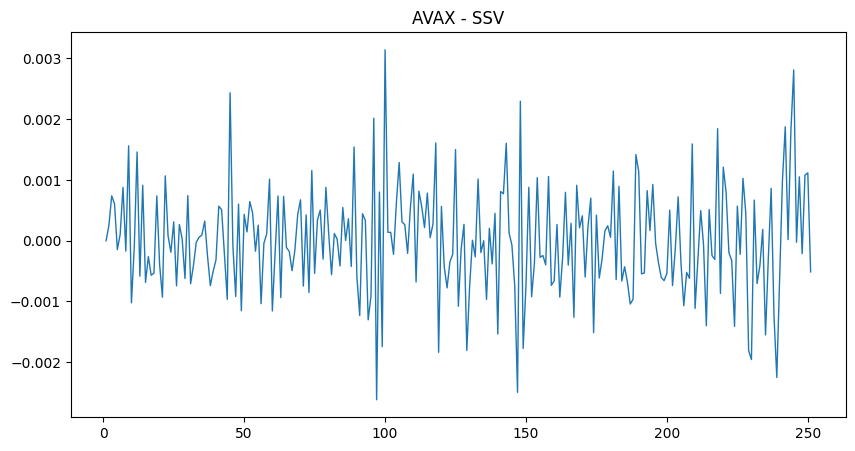

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.title('AVAX - SSV')
(avax_pct - ssv_pct)[0:252].plot(linewidth=1)
